# Load modules

In [1]:
import numpy as np
import pandas as pd
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample

import matplotlib.pyplot as plt
import seaborn as sns

import influxdb 
import pandas as pd
from dateutil import tz

# import the libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

import pandas as pd
import numpy as np
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
import ast
import pandas as pd
import seaborn as sns
sns.set_palette('husl')



# Load pipedream model information 

In [2]:
superjunctions = pd.read_csv('../data/waller_superjunctions.csv', index_col=0)  
superlinks = pd.read_csv('../data/waller_creek_superlinks.csv', index_col=0) 
subbasins = pd.read_excel('../data/Waller_HMS_model_data.xlsx', sheet_name=0)

# Specify simulation parameters

In [3]:
# Unit conversions
m_per_ft = 0.3048
ft_per_mi = 5280.
in_per_ft = 12.
s_per_min = 60
ns_per_s = 1e9

# Manual edits to model
superlinks.loc[21, ['g2', 'g3']] = 0.1, 7.777146367746631
superlinks['C_uk'] = 0.
superlinks['C_dk'] = 0.

# Manual edits to hydrology params
lag_time_adjust_ratio = 1.0
CN_adjust_ratio = 1.0

# Simulation params
sample_interval = 30
node_ids = ['Bridge1','Bridge2','Bridge3','Bridge4','Bridge5']
site_junction_name = 'J_WLR18_COMB_HEMP'
site_link_name = 'R_WLR16'
site_junction_index = 14
site_link_index = 21

# Define runoff functions

In [4]:
def scs_composite_CN(CN_C, A_Imp):
    # Convert CN to composite CN given percent impervious area
    m = (99 - CN_C) / 100
    b = CN_C
    y = m * A_Imp + b
    return y

In [5]:
def scs_uh_runoff(excess_precip__in, uh__dimless, area__sq_mi, sample_interval,lag_time__min):
    # Give unit hydrograph a time dimension corresponding to lag time
    uh = uh__dimless.copy()
    uh_time = uh['time ratios'] * lag_time__min * s_per_min * ns_per_s
    uh_time = pd.to_datetime(uh_time.rename('time'))
    uh = uh.set_index(uh_time)['discharge ratios']
    # Resample unit hydrograph to desired time interval
    uh = uh.resample(f'{sample_interval}s').mean().interpolate()
    uh = uh.values    
    # Scale unit hydrograph to have area of unity
    uh_scaled = uh / uh.sum()
    
    # Convolve excess precipitation and unit hydrograph
    conv = np.convolve(excess_precip__in.values, uh_scaled)
    # Convert to outflow 
    area__sq_ft = area__sq_mi * (ft_per_mi)**2
    conv__ft = conv / in_per_ft
    runoff__cfs = (conv__ft * area__sq_ft) / sample_interval
    runoff__cms = runoff__cfs * (m_per_ft)**3
    time_index = pd.date_range(start=excess_precip__in.index.min(), 
                               periods=runoff__cms.size, 
                               freq=f'{sample_interval}s')
    # Return runoff in cubic meters per second
    runoff__cms = pd.Series(runoff__cms, index=time_index)
    return runoff__cms

# Load LCRA flow, depth, and precipitation data

In [6]:
# Add LCRA data (Flow, depth, and precipitation data for the 'Waller Creek at 23rd Street' gage from the LCRA site.)
LCRA_2022 = pd.read_excel('../data/LCRA_Export/LCRA_Export_2022.xlsx')
LCRA_2023 = pd.read_excel('../data/LCRA_Export/LCRA_Export_2023.xlsx')
LCRA=pd.concat([LCRA_2022[8:],LCRA_2023[8:]])
LCRA = LCRA.set_index('Site Name')
LCRA.index.name = 'Time'
# Handle timezone
LCRA = LCRA.tz_localize('US/Central', nonexistent='shift_forward').tz_convert('UTC')
# Rename columns to be more descriptive
LCRA = LCRA.rename(columns={'W3A' : 'depth__ft', 'W3A.1' : 'flow_rate__cfs', 'W3A.3' : 'precip_tot__in'})
LCRA = LCRA.drop('W3A.2', axis=1)
# Filter dataset to time period


In [7]:
def precip_data(LCRA, start_date, end_date):
    LCRA = LCRA.loc[start_date:end_date]

    # Compute dt for each time bin
    LCRA['dt__s'] = np.roll(pd.Series(LCRA.index).diff(1).dt.seconds.values, -1)
    # Compute precipitation rate from total inches and dt
    LCRA['precip_rate__in_per_s'] = LCRA['precip_tot__in'] / LCRA['dt__s']

    # Compute inches of precipitation for desired sample interval
    precip__in = sample_interval * LCRA['precip_rate__in_per_s'].resample(f'{sample_interval}s').mean().interpolate()
    return precip__in

# Load ultrasonic sensor data

In [8]:
# Visualizing the actual depth of Waller Creeks  

# set up the lists(node_id and length between node and bottom)
node_id_list=['Bridge1','Bridge2','Bridge3','Bridge4','Bridge5']
length_ntb_list =[3911.6, 3175, 4927.6, 4978.4, 3556]
ntb_df=pd.DataFrame(length_ntb_list, columns=['depth'])
ntb_df=ntb_df.set_index([node_id_list])

#set up the influxDBClient 
client_dict = {'host' : 'ec2-3-91-156-8.compute-1.amazonaws.com',
               'port' : 8086,
               'username' : 'generic_node',
               'password' : 'GlareShellTwilight',
               'database' : 'RAW'}

client = influxdb.InfluxDBClient(**client_dict)

# definition of query to call influxdb data
def run_query(client, field, measurement, tags, pagesize=10000):
    
    #select the length of node to bottom  
    length_ntb=ntb_df.at[tags['node_id'],'depth']
    
    collect = []
    times = []
    values = []
    q = True
    pagenum = 0
    # Single quotes around tags might not always work
    tag_str = ' AND '.join(["{key}='{value}'".format(key=key, value=value) for key, value
                            in tags.items()])
    
    
    while q:
        q = client.query(("SELECT {field} FROM {measurement} WHERE {tags} "
                          "LIMIT {pagesize} OFFSET {page}")
                          .format(field=field, measurement=measurement, tags=tag_str,
                                  pagesize=pagesize, page=pagenum*pagesize))
        if q:
            collect.append(q[measurement])
           
        pagenum += 1
    for resultset in collect:
        for reading in resultset:
            
            #######time variable##########
            dt_gmt=pd.Timestamp(reading['time'],tz='Etc/GMT')
            
            #update time of data with local time zone 
            #difference_time =pd.Timestamp(reading['time'],tz='GMT')
            #local_time = dt_gmt +
            times.append(dt_gmt)
            
            #local_zone=tz.tzlocal() 
            #local_dt=dt_gmt.astimezone(local_zone)
            #times.append(local_dt)
            ################################
            values.append((length_ntb-reading[field])*0.001)
    s = pd.Series(values, index=times)
    
    s.index = pd.to_datetime(s.index)
    
    
    drop_index=s[s<=0].index
    s=s.drop(index=drop_index)


    return s





# Compute runoff into each superjunction

In [9]:
# Compute runoff into each superjunction
def Model_initialization(precip__in,subbasins,P_now,decay_function=lambda x: 0.):
    keepGoing=True
    while keepGoing:
        try:
            Q_in = {}
            CNs = []
            # Manual edits to hydrology params
            lag_time_adjust_ratio = 1.0
            CN_adjust_ratio = 1.0


            # For each subbasin...
            for i in range(len(subbasins)):
                P_now = 0.
                # Load subbasin parameters
                CN_C = subbasins['Curve Number'][i]
                A_Imp = subbasins['Impervious Percent'][i]
                area__sq_mi = subbasins['Area (mi2)'][i]
                downstream = subbasins['Downstream'][i]
                lag_time__min = subbasins['Lag Time'][i] * lag_time_adjust_ratio

                # Compute composite curve number
                CN = scs_composite_CN(CN_C, A_Imp) * CN_adjust_ratio
                CN = min(CN, 98)

                # Compute excess precipitation
                excess_precip_cum__in, excess_precip__in, P_now = scs_excess_precipitation(precip__in, CN,P_now,decay_function=decay_function)

                # Compute runoff using unit hydrograph
                runoff__cms = scs_uh_runoff(excess_precip__in, uh__dimless, area__sq_mi, sample_interval,lag_time__min)
                Q_in[downstream] = runoff__cms

            # Format flow input as DataFrame
            Q_in = pd.DataFrame.from_dict(Q_in)
            # Add flow input for missing sites
            Q_in['UPSTREAM_WALLER'] = Q_in['R_WLR01']
            Q_in['UPSTREAM_HEMPHILL'] = Q_in['R_HEM01']
            Q_in[[name for name in superjunctions['name'] if not name in Q_in.columns]] = 0.
            # Ensure flow input is only for superjunctions specified in table
            Q_in = Q_in[superjunctions['name'].tolist()]
            # Remove NaN values
            Q_in = Q_in.fillna(0.)
            # Copy flow input with original timestamps
            Q_in_orig = Q_in.copy()
            # Convert flow input index to integer index starting with zero
            Q_in.index = Q_in.index.astype(int) / 1e9
            Q_in.index -= Q_in.index.min()
            keepGoing=False
        
        except ValueError:
            keepGoing=True
        except KeyError :
            keepGoing=True
        except AssertionError:
            keepGoing=True


    return excess_precip__in,Q_in,P_now

In [10]:
# Run simulation without KF
def Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,load_data):
    load_data=load_data
    keepGoing=True
    while keepGoing:
        try:


            superlink = SuperLink(superlinks, superjunctions,internal_links=30, mobile_elements=True)
            

            H_j = []
            h_Ik = []
            Q_uk = []
            Q_dk = []

            # Set constant timestep (in seconds)

            # Add constant baseflow
#            baseflow = 0.22e-3 * np.ones(superlink._h_Ik.size)
            baseflow = 0.22e-5 * np.ones(superlink._h_Ik.size)
    
            # Create simulation context manager
            with Simulation(superlink, Q_in=Q_in) as simulation:
                print(load_data)
                simulation.model.load_state(load_data)
                # While simulation time has not expired...
                print(simulation.t,simulation.t_end)
                
                while simulation.t <= simulation.t_end:
                    # Step model forward in time
                    simulation.step(dt=dt, num_iter=8, Q_Ik=baseflow)
                    simulation.model.reposition_junctions()
                    # Print progress bar
                    simulation.print_progress()
                    # Save states
                    H_j.append(simulation.model.H_j.copy())
                    h_Ik.append(simulation.model.h_Ik.copy())
                    Q_uk.append(simulation.model.Q_uk.copy())
                    Q_dk.append(simulation.model.Q_dk.copy())

            time_index = pd.date_range(start=excess_precip__in.index.min(), 
                                       periods=len(H_j), 
                                       freq=f'{dt}s')

            # Convert saved states to dataframes
            H_j = pd.DataFrame(np.vstack(H_j), index=time_index, columns=superjunctions['name'])
            h_Ik = pd.DataFrame(np.vstack(h_Ik), index=time_index)
            Q_uk = pd.DataFrame(np.vstack(Q_uk), index=time_index, columns=superlinks['name'])
            Q_dk = pd.DataFrame(np.vstack(Q_dk), index=time_index, columns=superlinks['name'])

            # Compute depth
            h_j = H_j - simulation.model._z_inv_j
            final_data=simulation.model.states
            
            
            keepGoing=False
        
        except ValueError:
            keepGoing=True
        except KeyError :
            keepGoing=True
        except AssertionError:
            keepGoing=True

    
    return H_j,h_Ik,Q_uk,Q_dk,h_j,final_data

In [11]:


# Load pipedream model information 
superjunctions = pd.read_csv('../data/waller_superjunctions.csv', index_col=0)  
superlinks = pd.read_csv('../data/waller_creek_superlinks.csv', index_col=0) 
subbasins = pd.read_csv('../data/Waller_HMS_model_data.csv', index_col=0)

# Specify simulation parameters
# Unit conversions
m_per_ft = 0.3048
ft_per_mi = 5280.
in_per_ft = 12.
s_per_min = 60
ns_per_s = 1e9

# Manual edits to model
superlinks.loc[21, ['g2', 'g3']] = 0., 7.777146367746631
superlinks['C_uk'] = 0.
superlinks['C_dk'] = 0.


# Simulation params
sample_interval = 30

site_junction_name = 'J_WLR18_COMB_HEMP'
site_link_name = 'R_WLR16'
site_junction_index = 14
site_link_index = 21

# Load unit hydrograph
# Load dimensionless unit hydrograph
uh__dimless = pd.read_csv('../data/unit_hydrograph.csv')
# Drop unnecessary columns and rows
uh__dimless = uh__dimless[['time ratios', 'discharge ratios']].dropna()
dt = 10



# Plot simulation depth output against sensor data

In [12]:
def save_fig_depth(file_name):
   
    fig, ax = plt.subplots(figsize=(18, 6))

    s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge3'})
    x2=s[start_date:end_date]
    t_b2 =s[start_date:end_date].index
    plt.plot(t_b2,x2,'-', label='Bridge3')

    (m_per_ft * LCRA['depth__ft'][start_date:end_date]).plot(ax=ax, label='LCRA', c='r')




    h_j[site_junction_name].plot(ax=ax, label='Model', c='blue', zorder=3)


    plt.xlabel('Time', size=15)
    plt.ylabel('Depth (m)', size=15)
    plt.legend()
    plt.savefig('/Users/future_water_system/Desktop/Data/waller-creek-model_result/continous_scs/Multi_storm/all_data/'+file_name+'_without_bridge2&4&5_depth_99985.png')

def save_fig_flowrate(file_name):
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(Q_uk[site_link_name], label='Model', c='b')
    (m_per_ft**3 * LCRA['flow_rate__cfs'][start_date:end_date]).plot(ax=ax, label='LCRA', c='r')
    plt.legend()
    plt.xlabel('Time', size=15)
    plt.ylabel('Flow rate (cms)', size=15)
    plt.title('Flow rate comparison', size=15)
    plt.savefig('/Users/future_water_system/Desktop/Data/waller-creek-model_result/continous_scs/Multi_storm/all_data/'+file_name+'_flow_rate_99985.png')


def save_fig_calibration(file_name):
    fig, ax = plt.subplots(figsize=(10, 5))

    plt.scatter(m_per_ft * LCRA['depth__ft'][start_date:end_date], m_per_ft**3 * LCRA['flow_rate__cfs'][start_date:end_date], label='LCRA',color='red')
    plt.scatter(h_j[site_junction_name], Q_uk[site_link_name].values, label='Model' ,color='blue')
    plt.legend()
    plt.xlabel('Depth',size=13)
    plt.ylabel('Discharge',size=13)
    plt.savefig('/Users/future_water_system/Desktop/Data/waller-creek-model_result/continous_scs/Multi_storm/all_data/'+file_name+'_calibration_99985.png')
    
def save_fig_precip(file_name):
    fig, ax = plt.subplots(figsize=(18, 6))

    plt.plot(precip__in)
    plt.xlabel('Time', size=15)
    plt.ylabel('Precipitation (inch)', size=15)
    plt.title('Rain Intensity', size=15)
    plt.savefig('/Users/future_water_system/Desktop/Data/waller-creek-model_result/continous_scs/Multi_storm/all_data/'+file_name+'_precip_99985.png')


In [13]:
def scs_excess_precipitation(precip__in, CN,P_now, decay_function=lambda x: 0.):
    # Set up SCS parameters
    P = precip__in.values
    S = 1000 / CN -10 #potential maximum abstraction

    
    # Compute cumulative excess precipitation
    Pes = []
    Pes_inc = []
    Pe_prev = 0.
    P_now = P_now
    n = len(P)
    
    for t in range(n):
        Ia = 0.2 * S #inital abstraction
        Pt = P[t] #precipitaton at time t
     
        P_now = Pt + P_now  #accumulated precipitation
        loss = decay_function(P_now)
        if P_now - loss <= 0.:
            loss = 0.
        P_now = P_now - loss  ## I used this code for scs continous but still not fit well.
        
        if P_now <= Ia:
            Pe = 0.
        else:        
            Pe = (P_now - 0.2 * S)**2 / (P_now + 0.8 * S) #excess precipitation
        
        Pe_inc = Pe - Pe_prev + loss
        Pes.append(Pe)
        Pes_inc.append(Pe_inc)
        Pe_prev = Pe
        

    # Assign time index to excess precipitation output
    excess_precip_cum__in = pd.Series(Pes, index=precip__in.index)
    excess_precip__in = pd.Series(Pes_inc, index=precip__in.index)
    return excess_precip_cum__in, excess_precip__in, P_now 

In [14]:
def NSE(observed, modeled):
    num = ((observed - modeled)**2).sum()
    den = ((observed - observed.mean())**2).sum()
    return 1 - num / den

In [15]:
s = pd.read_csv('../data/Bridge3.csv', index_col=0)['Bridge3']
s.index = pd.to_datetime(s.index)

In [16]:
decay_function = lambda x: (1 - 0.99675)*x

startDate20220818_endDate20220910
{}
0 2083770.0
[--------------------------------------------------] 0.0% [0.24 s]{}
0 2083770.0
[--------------------------------------------------] 0.0% [0.0 s]

/Users/mdbartos/Git/pipedream/pipedream_solver/nsuperlink.py:1332: LinAlgWarning: Ill-conditioned matrix (rcond=8.9739e-131): result may not be accurate.
  H_j_next = scipy.linalg.solve(l, r)
/Users/mdbartos/Git/pipedream/pipedream_solver/nsuperlink.py:1332: LinAlgWarning: Ill-conditioned matrix (rcond=4.07945e-131): result may not be accurate.
  H_j_next = scipy.linalg.solve(l, r)


[==================================================] 100.0% [47.99 s]

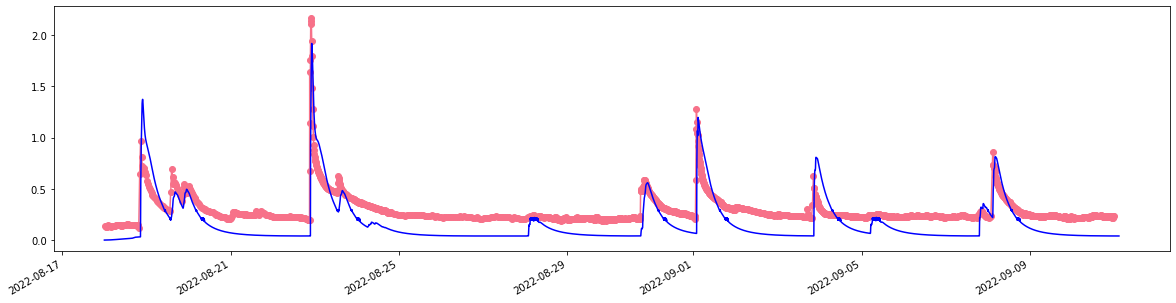

In [17]:

start_date_list = ['20220818']
end_date_list = ['20220910']


final_data={}
result=pd.DataFrame()

P_now=0

for start_date, end_date in zip(start_date_list,end_date_list):
    
    file_name='startDate'+str(start_date)+'_endDate'+str(end_date)
    print(file_name)

    precip__in=precip_data(LCRA, start_date, end_date)
    if precip__in.empty != True:
        excess_precip__in,Q_in,P_now=Model_initialization(precip__in,subbasins,P_now,decay_function=decay_function)
        H_j,h_Ik,Q_uk,Q_dk,h_j,final_data=Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,final_data)
        final_data['t']=0
        fig, ax = plt.subplots(figsize=(20, 5))

        ### Cache sensor data to avoid putting strain on server
        x2=s[start_date:end_date]
        t_b2 =s[start_date:end_date].index
        plt.plot(t_b2,x2,'o-', label='Bridge3')

        result=pd.concat([result, h_j])

        h_j[site_junction_name].plot(ax=ax, label='Model', c='blue', zorder=3)

In [18]:
observed = s.iloc[s.index.get_indexer(h_j.index, method='nearest')].values
modeled = h_j[site_junction_name].values
NSE(observed, modeled)

-0.5649817684304359

In [19]:
decay_function = lambda x: 0.007 * x**3

startDate20220818_endDate20220910
{}
0 2083770.0
[--------------------------------------------------] 0.0% [0.0 s]{}
0 2083770.0
[==================================================] 100.0% [48.44 s]

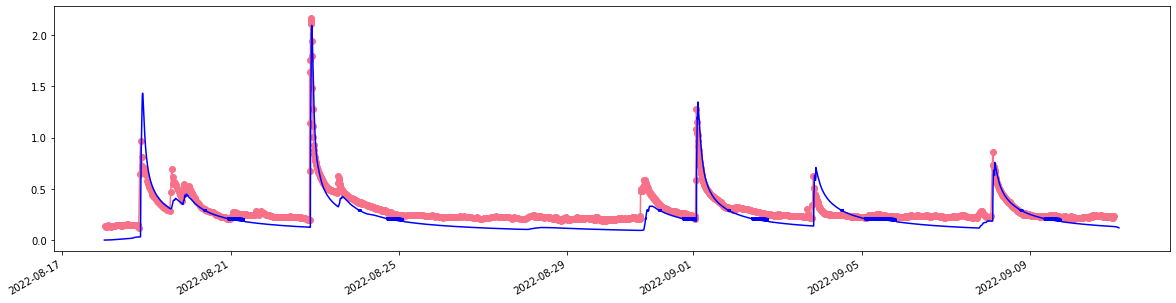

In [20]:

start_date_list = ['20220818']
end_date_list = ['20220910']


final_data={}
result=pd.DataFrame()

P_now=0

for start_date, end_date in zip(start_date_list,end_date_list):
    
    file_name='startDate'+str(start_date)+'_endDate'+str(end_date)
    print(file_name)

    precip__in=precip_data(LCRA, start_date, end_date)
    if precip__in.empty != True:
        excess_precip__in,Q_in,P_now=Model_initialization(precip__in,subbasins,P_now,decay_function=decay_function)
        H_j,h_Ik,Q_uk,Q_dk,h_j,final_data=Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,final_data)
        final_data['t']=0
        fig, ax = plt.subplots(figsize=(20, 5))

        ### Cache sensor data to avoid putting strain on server
        x2=s[start_date:end_date]
        t_b2 =s[start_date:end_date].index
        plt.plot(t_b2,x2,'o-', label='Bridge3')

        result=pd.concat([result, h_j])

        h_j[site_junction_name].plot(ax=ax, label='Model', c='blue', zorder=3)

In [21]:
observed = s.iloc[s.index.get_indexer(h_j.index, method='nearest')].values
modeled = h_j[site_junction_name].values
NSE(observed, modeled)

0.32858727391974807

In [22]:
decay_function = lambda x: 0.007 * x**5

startDate20220818_endDate20220910
{}
0 2083770.0
[=-------------------------------------------------] 2.0% [0.97 s]{}
0 2083770.0
[==================================================] 100.0% [249.36 s]

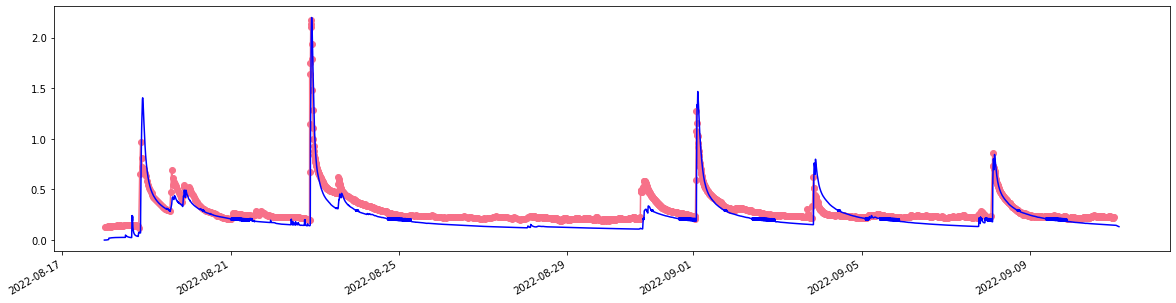

In [23]:

start_date_list = ['20220818']
end_date_list = ['20220910']


final_data={}
result=pd.DataFrame()

P_now=0

for start_date, end_date in zip(start_date_list,end_date_list):
    
    file_name='startDate'+str(start_date)+'_endDate'+str(end_date)
    print(file_name)

    precip__in=precip_data(LCRA, start_date, end_date)
    if precip__in.empty != True:
        excess_precip__in,Q_in,P_now=Model_initialization(precip__in,subbasins,P_now,decay_function=decay_function)
        H_j,h_Ik,Q_uk,Q_dk,h_j,final_data=Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,final_data)
        final_data['t']=0
        fig, ax = plt.subplots(figsize=(20, 5))

        ### Cache sensor data to avoid putting strain on server
        x2=s[start_date:end_date]
        t_b2 =s[start_date:end_date].index
        plt.plot(t_b2,x2,'o-', label='Bridge3')

        result=pd.concat([result, h_j])

        h_j[site_junction_name].plot(ax=ax, label='Model', c='blue', zorder=3)

In [24]:
observed = s.iloc[s.index.get_indexer(h_j.index, method='nearest')].values
modeled = h_j[site_junction_name].values
NSE(observed, modeled)

0.45197256124332763

In [25]:
decay_function = lambda x: 0.003 * x**5

startDate20220818_endDate20220910
{}
0 2083770.0
[==================================================] 100.0% [48.78 s]

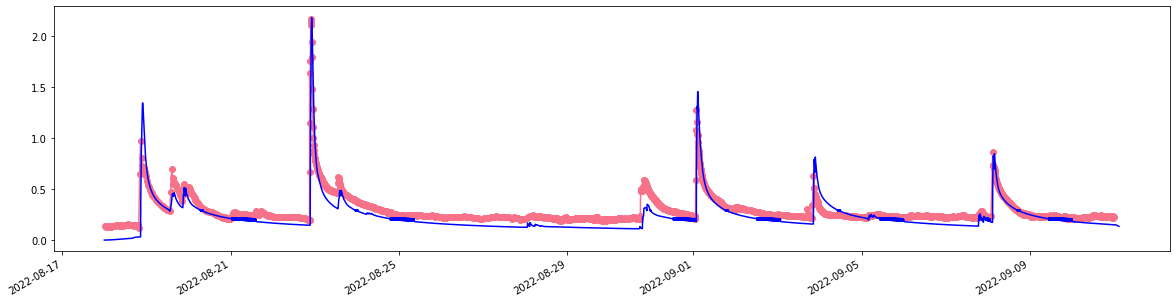

In [26]:

start_date_list = ['20220818']
end_date_list = ['20220910']


final_data={}
result=pd.DataFrame()

P_now=0

for start_date, end_date in zip(start_date_list,end_date_list):
    
    file_name='startDate'+str(start_date)+'_endDate'+str(end_date)
    print(file_name)

    precip__in=precip_data(LCRA, start_date, end_date)
    if precip__in.empty != True:
        excess_precip__in,Q_in,P_now=Model_initialization(precip__in,subbasins,P_now,decay_function=decay_function)
        H_j,h_Ik,Q_uk,Q_dk,h_j,final_data=Model_simulation(excess_precip__in,Q_in,dt,superlinks,superjunctions,final_data)
        final_data['t']=0
        fig, ax = plt.subplots(figsize=(20, 5))

        ### Cache sensor data to avoid putting strain on server
        x2=s[start_date:end_date]
        t_b2 =s[start_date:end_date].index
        plt.plot(t_b2,x2,'o-', label='Bridge3')

        result=pd.concat([result, h_j])

        h_j[site_junction_name].plot(ax=ax, label='Model', c='blue', zorder=3)

In [27]:
observed = s.iloc[s.index.get_indexer(h_j.index, method='nearest')].values
modeled = h_j[site_junction_name].values
NSE(observed, modeled)

0.47796129673994625

In [64]:
decay_function = lambda x: 0.001 * x**3

In [65]:
runoffs = []
for i in range(len(subbasins)):
    P_now = 0.
    # Load subbasin parameters
    CN_C = subbasins['Curve Number'][i]
    A_Imp = subbasins['Impervious Percent'][i]
    area__sq_mi = subbasins['Area (mi2)'][i]
    downstream = subbasins['Downstream'][i]
    lag_time__min = subbasins['Lag Time'][i] * lag_time_adjust_ratio

    # Compute composite curve number
    CN = scs_composite_CN(CN_C, A_Imp) * CN_adjust_ratio
    CN = min(CN, 98)

    # Compute excess precipitation
    excess_precip_cum__in, excess_precip__in, P_now = scs_excess_precipitation(precip__in, CN,P_now,decay_function=decay_function)

    # Compute runoff using unit hydrograph
    runoff__cms = scs_uh_runoff(excess_precip__in, uh__dimless, area__sq_mi, sample_interval,lag_time__min)
    runoffs.append(runoff__cms)

Text(0, 0.5, 'Total Runoff (cms)')

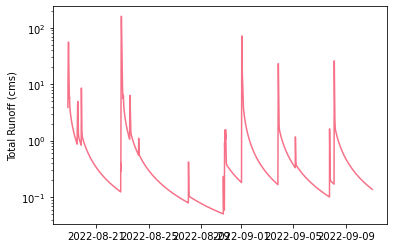

In [66]:
plt.semilogy(sum(runoffs).loc['20220818 20:00:00':end_date])
plt.ylabel('Total Runoff (cms)')